# RLD | Zakari AIT OUAZZOU 3702777

# TME 1 : Problèmes de Bandits

## Lecture de données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'P:\\Master\\RLD\\TME\\1'

In [3]:
f = open("CTR.txt", "r")

# data[i][j]
# i -> article index
# j ->  0 -> article desc vector
#       1 -> article ad clicks

data = [[] for i in range(5000)]
for line in f:
    spLine = line.split(":")
    data[int(spLine[0])].append(list(map(float, spLine[1].split(";"))))
    data[int(spLine[0])].append(list(map(float, spLine[2].split(";"))))
pData = pd.DataFrame(data, columns=["Desc", "Clicks"])
pData.head()

,Desc,Clicks
0,"[0.74837091377052, 0.8352077827766918, 0.07669...","[0.10341905704918021, 0.19069778281037159, 0.0..."
1,"[0.16841851887985582, 0.1337544632704264, 0.43...","[0.0, 0.0, 0.0, 0.020827097947315257, 0.0, 0.0..."
2,"[0.4852873193263283, 0.5669886866963504, 0.041...","[0.10957461446818696, 0.13662644655693568, 0.0..."
3,"[0.6222307845696199, 0.1961234321879859, 0.131...","[0.0, 0.1510688622593973, 0.0, 0.1272393919522..."
4,"[0.3317104123038488, 0.08641097481469784, 0.02...","[0.0, 0.10921436423915529, 0.0, 0.151937820362..."


In [4]:
best_res = [np.argmax(data[ex][1]) for ex in range(len(data))]
best_r = [np.max(data[ex][1]) for ex in range(len(data))]
best_cum_sum = np.cumsum(best_r)

## Baseline

In [5]:
def drawRes(data, res, labels):
    for strat in res:
        currSum = 0
        currSumOpt = 0
        espL = []
        for i in range(len(strat)):
            currSum += data[i][1][strat[i]]
            espL.append(currSum)
        plt.plot(espL)
    plt.legend(labels)
    plt.show()

In [6]:
def drawResRegret(data, res, labels):
    plt.figure(figsize=(5, 5))
    for strat in res:
        currSum = 0
        currSumOpt = 0
        espL = []
        for i in range(len(strat)):
            currSum += data[i][1][strat[i]]
            espL.append(best_cum_sum[i] - currSum)
        plt.plot(espL)
    plt.legend(labels)
    plt.show()
    

In [7]:
best_cum_sum[4500]

1377.2681457757549

### Stratégie Random

In [8]:
from random import randint
def randomStrat(data):
    res = []
    for t in range(len(data)):
        res.append(randint(0,9))
    return res

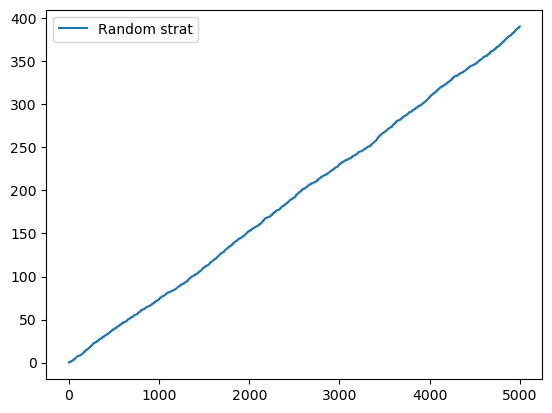

In [9]:
drawRes(data, [randomStrat(data)], ["Random strat"])

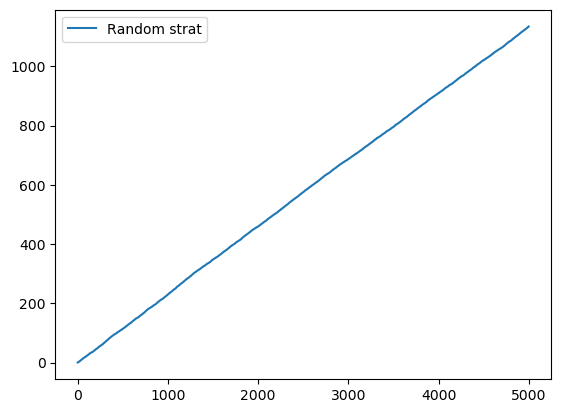

In [10]:
drawResRegret(data, [randomStrat(data)], ["Random strat"])

### Stratégie StaticBest

In [11]:
def staticBestStrat(data):
    cumuls = [0 for i in range(10)]
    res = []
    for j in range(len(data)):
        for i in range(len(data[0][1])):
            cumuls[i] += data[j][1][i]
        res.append(np.argmax(cumuls))
    return res

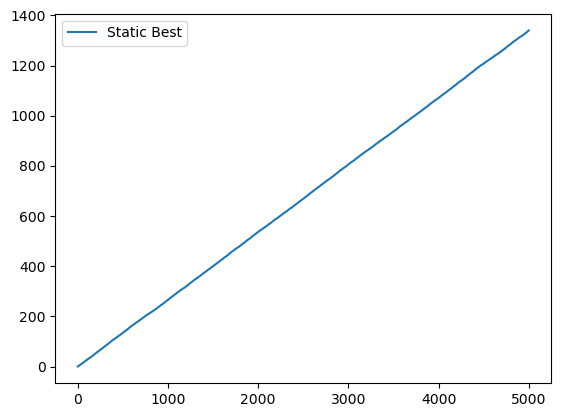

In [12]:
drawRes(data, [staticBestStrat(data)], ["Static Best"])

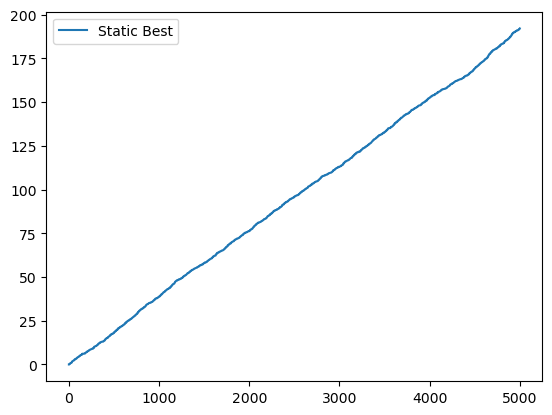

In [13]:
drawResRegret(data, [staticBestStrat(data)], ["Static Best"])

### Stratégie Optimale

In [14]:
def optimalStrat(data):
    res = []
    for j in range(len(data)):
        res.append(np.argmax(data[j][1]))
    return res

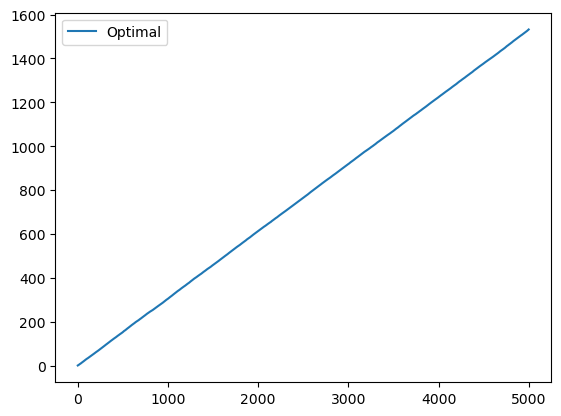

In [15]:
drawRes(data, [optimalStrat(data)], ["Optimal"])

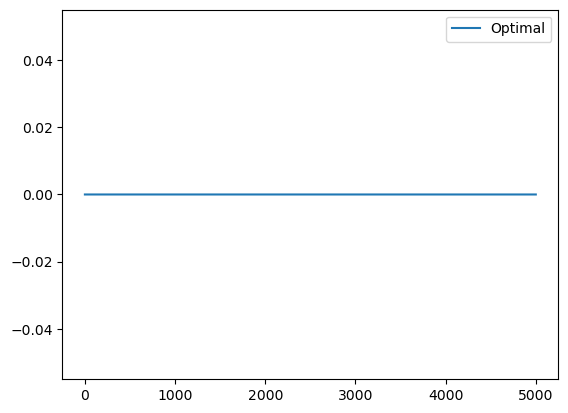

In [16]:
drawResRegret(data, [optimalStrat(data)], ["Optimal"])

### Comp all Strats:

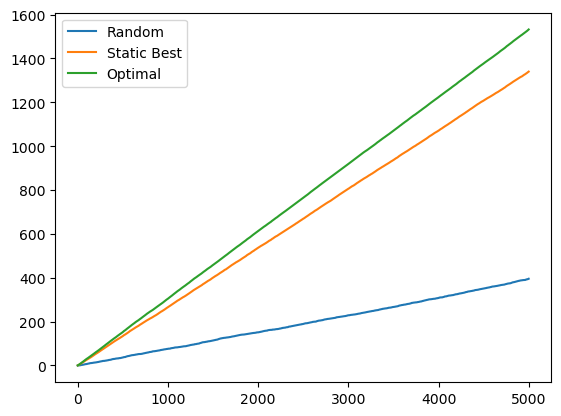

In [17]:
drawRes(data, [randomStrat(data), staticBestStrat(data), optimalStrat(data)], ["Random", "Static Best", "Optimal"])

## UCB

In [18]:
def UCBStrat(data):
    # b[i][j]
    # j -> ad index
    # i ->  0 -> ad cum_sum
    #       1 -> ad s
    b = [[0 for i in range(len(data[0][1]))], [0 for i in range(len(data[0][1]))]]
    res = []
    for t in range(0,10):
        b[0][t] += data[t][1][t]
        b[1][t] += 1
        res.append(t)
    for t in range(10,len(data)):
        sel = np.argmax([ m + np.sqrt(2*np.log(t)/b[1][i]) for i, m in enumerate(b[0])])
        b[0][sel] += data[t][1][sel]
        b[1][sel] += 1
        res.append(sel)
    return res

In [19]:
print(data[0][1])

[0.10341905704918021, 0.19069778281037159, 0.0, 0.10240139196802925, 0.0363124254124334, 0.07456195450906297, 0.2347024151796051, 0.0, 0.0, 0.07857372422425657]


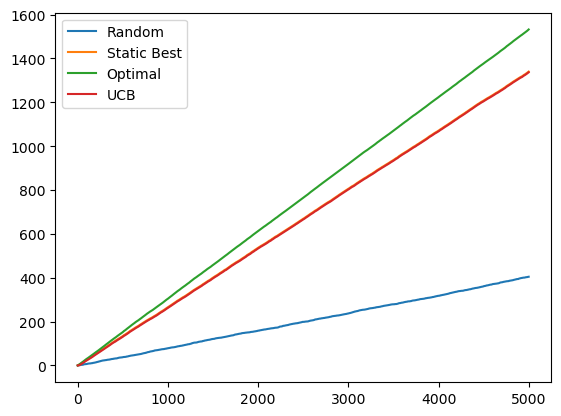

In [20]:
drawRes(data, [randomStrat(data), staticBestStrat(data), optimalStrat(data), UCBStrat(data)], ["Random", "Static Best", "Optimal", "UCB"])

## Lin-UCB

In [21]:
def LinUCBStrat(data, alpha, Training = 1):
    action_number = len(data[0][1])
    feature_number = len(data[0][0])
    article_number = len(data)
    actions = range(action_number)
    A = np.array([np.identity(feature_number) for a in actions])
    b = [[0 for i in range(feature_number)] for a in actions]
    A_i = [np.linalg.inv(A[a]) for a in actions]
    # Pour ne pas réinverser toutes les matrices A à chaque fois
    sel = 0
    for T in range(Training):
        res = []
        for t in range(article_number):
            x_t = np.array(data[t][0])
            A_i[sel] = np.linalg.inv(A[sel])
            theta = [A_i[a]@b[a] for a in actions]
            p_a = [theta[a].T@x_t + alpha*np.sqrt(x_t.T@A_i[a]@x_t) for a in actions]
            sel = np.argmax(p_a)
            A[sel] = A[sel] + x_t@x_t.T
            b[sel] = b[sel] + data[t][1][sel]*x_t
            res.append(sel)
    return res

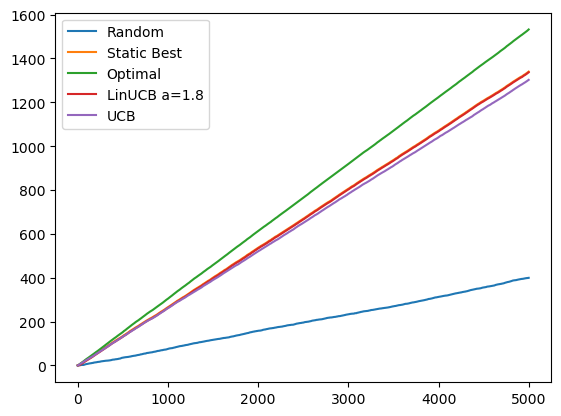

In [28]:
drawRes(data, [randomStrat(data), staticBestStrat(data), optimalStrat(data), UCBStrat(data), LinUCBStrat(data, 1.8, 1000)], ["Random", "Static Best", "Optimal", "LinUCB a=1.8", "UCB"])

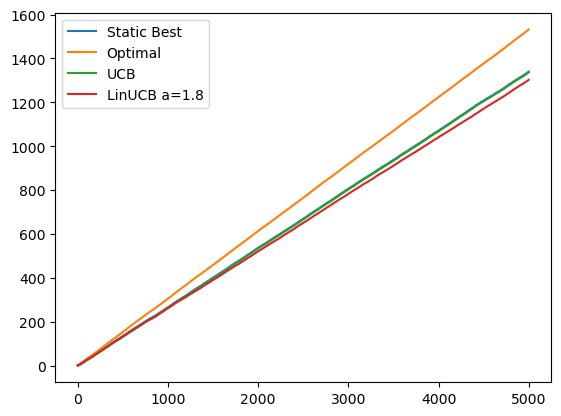

In [27]:
drawRes(data, [staticBestStrat(data), optimalStrat(data), UCBStrat(data), LinUCBStrat(data, 1.8, 1000)], ["Static Best", "Optimal", "UCB", "LinUCB a=1.8"])

In [23]:
alphas = [alpha*0.1 for alpha in range(0, 22, 2)]

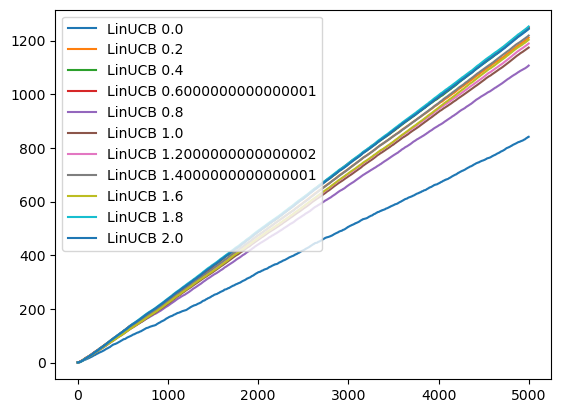

In [24]:
drawRes(data, [LinUCBStrat(data, alpha) for alpha in alphas], ["LinUCB " + str(alpha) for alpha in alphas])